In [ ]:
# CELL 0 — Mount Drive and install required libraries
from google.colab import drive
drive.mount('/content/drive')

# Install compatible tensorflow and helper libs (run once per new runtime)
!pip install -q tensorflow==2.19.0 scikit-image scikit-learn pillow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CELL 1 — imports and constants (edit paths here)
import os, time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU, ReLU
from keras.initializers import RandomNormal
from keras.utils import img_to_array, load_img
from sklearn.metrics import confusion_matrix
from skimage import color
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

# Set these paths before running
DATASET_PATH = "/content/drive/MyDrive/landscape_Images/"   # folder that contains 'color' and 'gray' subfolders
CKPT_DIR = "/content/drive/MyDrive/checkpoint1"             # where to save models / samples / history

# Training settings
IMG_SIZE = 256
NUM_IMAGES = 1000        # number of images to load (change to dataset size)
BATCH_SIZE = 16
EPOCHS = 50

os.makedirs(CKPT_DIR, exist_ok=True)

print("TF version:", tf.__version__)
print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE, "EPOCHS:", EPOCHS)
print("DATASET_PATH:", DATASET_PATH)
print("CKPT_DIR:", CKPT_DIR)

TF version: 2.19.0
IMG_SIZE: 256 BATCH_SIZE: 16 EPOCHS: 50
DATASET_PATH: /content/drive/MyDrive/landscape_Images/
CKPT_DIR: /content/drive/MyDrive/checkpoint1


**Load dataset**

Loaded shapes: (1000, 256, 256, 3) (1000, 256, 256, 3)
Train/Val sizes: 850 150


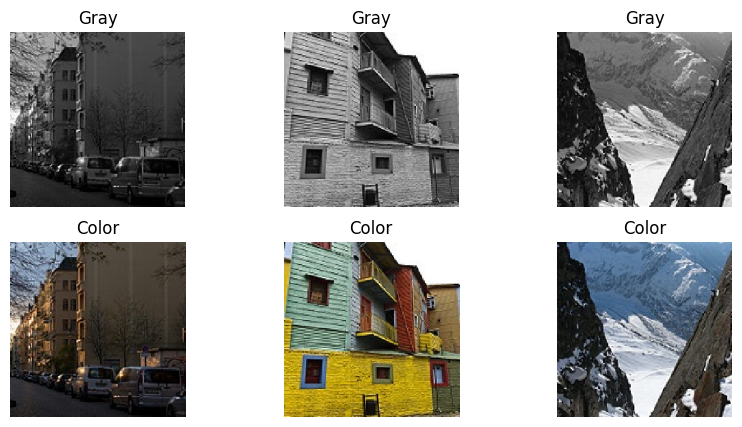

In [ ]:
# CELL 2 — load and preprocess images (resizing + scaling to [-1,1])
def load_images(color_dir, gray_dir, num_images=NUM_IMAGES, img_size=IMG_SIZE):
    color_paths = sorted(glob(os.path.join(color_dir, "*.jpg")))[:num_images]
    gray_paths  = sorted(glob(os.path.join(gray_dir,  "*.jpg")))[:num_images]
    n = len(color_paths)
    X_color = np.zeros((n, img_size, img_size, 3), dtype=np.float32)
    X_gray  = np.zeros((n, img_size, img_size, 3), dtype=np.float32)
    for i, (c, g) in enumerate(zip(color_paths, gray_paths)):
        cimg = img_to_array(load_img(c, target_size=(img_size,img_size)))
        gimg = img_to_array(load_img(g, target_size=(img_size,img_size)))
        X_color[i] = (cimg / 127.5) - 1.0   # scale to [-1,1]
        X_gray[i]  = (gimg / 127.5) - 1.0
    return X_gray, X_color

# paths to subfolders
color_dir = os.path.join(DATASET_PATH, "color")
gray_dir  = os.path.join(DATASET_PATH, "gray")

gray_images, color_images = load_images(color_dir, gray_dir, num_images=NUM_IMAGES)
print("Loaded shapes:", gray_images.shape, color_images.shape)

# quick train/val split
split = int(0.85 * gray_images.shape[0])
train_gray, val_gray = gray_images[:split], gray_images[split:]
train_color, val_color = color_images[:split], color_images[split:]
print("Train/Val sizes:", train_gray.shape[0], val_gray.shape[0])

# show a few sample pairs (rescaled to [0,1] for viewing)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(2,3,i+1); plt.imshow(((train_gray[i]+1)/2).astype(np.float32)); plt.title("Gray"); plt.axis('off')
    plt.subplot(2,3,i+4); plt.imshow(((train_color[i]+1)/2).astype(np.float32)); plt.title("Color"); plt.axis('off')
plt.show()

**Model definitions (Generator + Discriminator)**

In [ ]:
# CELL 3 — model blocks and network definitions (same as your architecture)
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    inputs = Input(shape=input_shape, name="InputLayer")
    encoder = [downscale(64), downscale(128), downscale(256), downscale(512), downscale(512), downscale(512), downscale(512)]
    latent_space = downscale(512)
    decoder = [upscale(512), upscale(512), upscale(512), upscale(512), upscale(256), upscale(128), upscale(64)]
    x = inputs
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)
    x = latent_space(x)
    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])
    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer=initializer, activation='tanh', padding='same')(x)
    return Model(inputs=inputs, outputs=outputs, name="Generator")

# Discriminator remains the same (no feature-matching here)
def Discriminator():
    image = Input(shape=(IMG_SIZE,IMG_SIZE,3), name="ImageInput")
    target = Input(shape=(IMG_SIZE,IMG_SIZE,3), name="TargetInput")
    x = concatenate([image, target])
    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)
    initializer = RandomNormal(stddev=0.02, seed=42)
    x = Conv2D(512, kernel_size=4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=4, kernel_initializer=initializer)(x)  # patch output
    return Model(inputs=[image, target], outputs=x, name="Discriminator")

generator = Generator()
discriminator = Discriminator()
generator.summary()
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,328 │ InputLayer[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,426,115 (207.62 MB)

 Trainable params: 54,415,107 (207.58 MB)

 Non-trainable params: 11,008 (43.00 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInput          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TargetInput         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ ImageInput[0][0], │
│ (Concatenate)       │ 6)                │            │ TargetInput[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,400 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │  1,050,624 │ sequential_16[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 29, 29,    │  4,194,304 │ sequential_17[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 29,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 29, 29,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 26, 26, 1) │      8,193 │ leaky_re_lu_18[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,393,153 (20.57 MB)

 Trainable params: 5,390,721 (20.56 MB)

 Non-trainable params: 2,432 (9.50 KB)

**optimizers and base losses**

In [ ]:
# CELL 4 — base losses and optimizers
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # adversarial loss (you may later switch to MSE for LSGAN)
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**Perceptual (VGG) feature extractor + color constancy loss**

In [ ]:
# CELL 5 — VGG perceptual extractor and color-constancy loss
# Build VGG19 feature extractor (frozen)
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
selected_layers = ['block3_conv3', 'block4_conv3']
vgg_outputs = [vgg.get_layer(name).output for name in selected_layers]
vgg_model = Model(inputs=vgg.input, outputs=vgg_outputs)
vgg_model.trainable = False

# perceptual loss function
def perceptual_loss(y_true, y_pred):
    # y_true, y_pred expected in [-1,1]
    t_true = (y_true + 1.0) * 127.5
    t_pred = (y_pred + 1.0) * 127.5
    t_true = preprocess_input(t_true)  # VGG preprocessing
    t_pred = preprocess_input(t_pred)
    feat_true = vgg_model(t_true)
    feat_pred = vgg_model(t_pred)
    loss = 0.0
    for ft, fp in zip(feat_true, feat_pred):
        loss += tf.reduce_mean(tf.square(ft - fp))
    return loss

# color constancy loss (match mean RGB per image)
def color_constancy_loss(y_true, y_pred):
    t = (y_true + 1.0) / 2.0  # [0,1]
    p = (y_pred + 1.0) / 2.0
    mean_true = tf.reduce_mean(t, axis=[1,2])  # shape (batch, 3)
    mean_pred = tf.reduce_mean(p, axis=[1,2])
    return tf.reduce_mean(tf.square(mean_true - mean_pred))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Updated generator & discriminator loss functions**

In [ ]:
# CELL 6 — combine losses and define generator/discriminator loss helpers
L1_WEIGHT = 100.0
PERC_WEIGHT = 0.01       # perceptual weight; tune 0.001 -> 0.1
COLOR_WEIGHT = 1.0       # color constancy weight

def generator_loss_fn(disc_generated, generated_output, target_image):
    # adversarial loss (BCE from logits)
    gan_loss = bce(tf.ones_like(disc_generated), disc_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    perc = perceptual_loss(target_image, generated_output)
    color = color_constancy_loss(target_image, generated_output)
    total_loss = gan_loss + (L1_WEIGHT * l1_loss) + (PERC_WEIGHT * perc) + (COLOR_WEIGHT * color)
    return total_loss, gan_loss, l1_loss, perc, color

def discriminator_loss_fn(discriminator_real_output, discriminator_generated_output):
    real_loss = bce(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = bce(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Dataset pipeline (tf.data) and metrics dict**

In [ ]:
# CELL 7 — tf.data pipelines and metrics
train_ds = tf.data.Dataset.from_tensor_slices((train_gray, train_color)).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_gray, val_color)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_metrics = {
    "g_total_loss": tf.keras.metrics.Mean(),
    "g_gan_loss": tf.keras.metrics.Mean(),
    "g_l1_loss": tf.keras.metrics.Mean(),
    "g_perc_loss": tf.keras.metrics.Mean(),
    "g_color_loss": tf.keras.metrics.Mean(),
    "d_loss": tf.keras.metrics.Mean(),
    "d_acc": tf.keras.metrics.Mean(),
}

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(), "Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

Train batches: 53 Val batches: 10


**Training step with perceptual & color loss logged**

In [ ]:
# CELL 8 — train_step (tf.function)
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_output = generator(input_image, training=True)
        discriminator_real = discriminator([input_image, target], training=True)
        discriminator_generated = discriminator([input_image, generated_output], training=True)

        g_total, g_gan, g_l1, g_perc, g_color = generator_loss_fn(discriminator_generated, generated_output, target)
        d_loss = discriminator_loss_fn(discriminator_real, discriminator_generated)

    gen_grads = gen_tape.gradient(g_total, generator.trainable_variables)
    disc_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    # discriminator accuracy metric (patch wise)
    real_preds = tf.sigmoid(discriminator_real)
    fake_preds = tf.sigmoid(discriminator_generated)
    real_acc = tf.reduce_mean(tf.cast(real_preds > 0.5, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_preds <= 0.5, tf.float32))
    disc_acc = 0.5 * (real_acc + fake_acc)

    # update metrics
    train_metrics["g_total_loss"].update_state(g_total)
    train_metrics["g_gan_loss"].update_state(g_gan)
    train_metrics["g_l1_loss"].update_state(g_l1)
    train_metrics["g_perc_loss"].update_state(g_perc)
    train_metrics["g_color_loss"].update_state(g_color)
    train_metrics["d_loss"].update_state(d_loss)
    train_metrics["d_acc"].update_state(disc_acc)

**Validation function (PSNR/SSIM) and sample saving**

In [ ]:
# CELL 9 — validation evaluation function + sample saver
def eval_on_val_and_save_samples(epoch, save_n=3):
    psnr_vals = []
    ssim_vals = []
    for idx, (inp, tar) in enumerate(val_ds):
        pred = generator(inp, training=False)
        pred_01 = (pred + 1.0) / 2.0
        tar_01  = (tar + 1.0) / 2.0
        psnr_vals.append(tf.image.psnr(pred_01, tar_01, max_val=1.0).numpy())
        ssim_vals.append(tf.image.ssim(pred_01, tar_01, max_val=1.0).numpy())
        if idx == 0:
            # save first batch samples to CKPT_DIR
            for i in range(min(save_n, inp.shape[0])):
                inp_img = ((inp[i] + 1)/2).numpy()
                tar_img = ((tar[i] + 1)/2).numpy()
                pred_img = pred_01[i].numpy()
                # side-by-side image
                fig, axs = plt.subplots(1,3,figsize=(12,4))
                axs[0].imshow(np.clip(inp_img,0,1)); axs[0].set_title("Gray Input"); axs[0].axis('off')
                axs[1].imshow(np.clip(tar_img,0,1)); axs[1].set_title("Ground Truth"); axs[1].axis('off')
                axs[2].imshow(np.clip(pred_img,0,1)); axs[2].set_title("Predicted"); axs[2].axis('off')
                sample_path = os.path.join(CKPT_DIR, f"epoch_{epoch+1}_sample_{i}.png")
                plt.savefig(sample_path, bbox_inches='tight')
                plt.close(fig)
    mean_psnr = np.concatenate(psnr_vals).mean()
    mean_ssim = np.concatenate(ssim_vals).mean()
    return mean_psnr, mean_ssim

**Full training loop**

In [ ]:
# CELL 10 — training loop
history = {k: [] for k in ["g_total_loss","g_gan_loss","g_l1_loss","g_perc_loss","g_color_loss","d_loss","d_acc","val_psnr","val_ssim"]}

for epoch in range(EPOCHS):
    # reset metrics
    for m in train_metrics.values():
        m.reset_state()
    start = time.time()
    for step, (inp, tar) in enumerate(train_ds):
        train_step(inp, tar)
        # print periodic step logs
        if (step+1) % 50 == 0:
            print(f"Epoch {epoch+1} Step {step+1}: g_total={train_metrics['g_total_loss'].result().numpy():.4f}, d_loss={train_metrics['d_loss'].result().numpy():.4f}")
    # validate
    val_psnr, val_ssim = eval_on_val_and_save_samples(epoch, save_n=3)
    # record history
    history["g_total_loss"].append(train_metrics["g_total_loss"].result().numpy())
    history["g_gan_loss"].append(train_metrics["g_gan_loss"].result().numpy())
    history["g_l1_loss"].append(train_metrics["g_l1_loss"].result().numpy())
    history["g_perc_loss"].append(train_metrics["g_perc_loss"].result().numpy())
    history["g_color_loss"].append(train_metrics["g_color_loss"].result().numpy())
    history["d_loss"].append(train_metrics["d_loss"].result().numpy())
    history["d_acc"].append(train_metrics["d_acc"].result().numpy())
    history["val_psnr"].append(val_psnr)
    history["val_ssim"].append(val_ssim)

    print(f"Epoch {epoch+1}/{EPOCHS} - g_total: {history['g_total_loss'][-1]:.4f}, g_perc: {history['g_perc_loss'][-1]:.6f}, g_color: {history['g_color_loss'][-1]:.6f}, d_loss: {history['d_loss'][-1]:.4f}, d_acc: {history['d_acc'][-1]:.4f}, val_psnr: {val_psnr:.3f}, val_ssim: {val_ssim:.3f} - time: {time.time()-start:.1f}s")

    # save models and history every 5 epochs
    if (epoch+1) % 5 == 0:
        gen_path = os.path.join(CKPT_DIR, f"generator_epoch_{epoch+1}.h5")
        disc_path = os.path.join(CKPT_DIR, f"discriminator_epoch_{epoch+1}.h5")
        generator.save(gen_path)
        discriminator.save(disc_path)
        # save history CSV
        import pandas as pd
        pd.DataFrame(history).to_csv(os.path.join(CKPT_DIR, "training_history.csv"), index=False)
        print("Saved checkpoints and history.")

Epoch 1 Step 50: g_total=1915.8110, d_loss=1.0307
Epoch 1/50 - g_total: 1875.8480, g_perc: 184520.546875, g_color: 0.006828, d_loss: 0.9974, d_acc: 0.7852, val_psnr: 15.220, val_ssim: 0.280 - time: 75.4s
Epoch 2 Step 50: g_total=1038.9520, d_loss=0.4782
Epoch 2/50 - g_total: 1029.9618, g_perc: 100809.312500, g_color: 0.004357, d_loss: 0.4706, d_acc: 0.9505, val_psnr: 17.748, val_ssim: 0.427 - time: 51.2s
Epoch 3 Step 50: g_total=833.0728, d_loss=0.3723
Epoch 3/50 - g_total: 833.3353, g_perc: 81247.031250, g_color: 0.004524, d_loss: 0.3664, d_acc: 0.9593, val_psnr: 18.769, val_ssim: 0.488 - time: 52.2s
Epoch 4 Step 50: g_total=763.8493, d_loss=0.1293
Epoch 4/50 - g_total: 765.1473, g_perc: 74425.898438, g_color: 0.004568, d_loss: 0.1265, d_acc: 0.9966, val_psnr: 19.580, val_ssim: 0.550 - time: 52.3s
Epoch 5 Step 50: g_total=695.3998, d_loss=0.0606


Epoch 5/50 - g_total: 696.2772, g_perc: 67513.351562, g_color: 0.004631, d_loss: 0.0659, d_acc: 0.9988, val_psnr: 19.582, val_ssim: 0.538 - time: 52.3s


Saved checkpoints and history.
Epoch 6 Step 50: g_total=675.4100, d_loss=0.7489
Epoch 6/50 - g_total: 677.5322, g_perc: 65827.296875, g_color: 0.004292, d_loss: 0.7119, d_acc: 0.8960, val_psnr: 19.803, val_ssim: 0.552 - time: 52.4s
Epoch 7 Step 50: g_total=627.2242, d_loss=0.0482
Epoch 7/50 - g_total: 627.2018, g_perc: 60642.324219, g_color: 0.004034, d_loss: 0.0467, d_acc: 0.9998, val_psnr: 19.945, val_ssim: 0.572 - time: 52.1s
Epoch 8 Step 50: g_total=604.7576, d_loss=0.0330
Epoch 8/50 - g_total: 607.7933, g_perc: 58666.175781, g_color: 0.004014, d_loss: 0.0329, d_acc: 0.9994, val_psnr: 20.213, val_ssim: 0.603 - time: 53.0s
Epoch 9 Step 50: g_total=563.4711, d_loss=0.3491
Epoch 9/50 - g_total: 562.5876, g_perc: 54232.164062, g_color: 0.003628, d_loss: 0.3335, d_acc: 0.9573, val_psnr: 20.324, val_ssim: 0.621 - time: 52.0s
Epoch 10 Step 50: g_total=517.5969, d_loss=0.0390


Epoch 10/50 - g_total: 518.4503, g_perc: 49816.093750, g_color: 0.003636, d_loss: 0.0380, d_acc: 0.9995, val_psnr: 20.388, val_ssim: 0.621 - time: 51.8s


Saved checkpoints and history.
Epoch 11 Step 50: g_total=471.1299, d_loss=0.1474
Epoch 11/50 - g_total: 474.3034, g_perc: 45475.339844, g_color: 0.002972, d_loss: 0.1413, d_acc: 0.9797, val_psnr: 20.555, val_ssim: 0.649 - time: 52.0s
Epoch 12 Step 50: g_total=422.6483, d_loss=0.0259
Epoch 12/50 - g_total: 418.8378, g_perc: 39923.582031, g_color: 0.002876, d_loss: 0.0277, d_acc: 0.9998, val_psnr: 20.464, val_ssim: 0.619 - time: 51.9s
Epoch 13 Step 50: g_total=378.9001, d_loss=0.0230
Epoch 13/50 - g_total: 380.6399, g_perc: 36102.394531, g_color: 0.002825, d_loss: 0.0231, d_acc: 0.9996, val_psnr: 20.509, val_ssim: 0.637 - time: 51.9s
Epoch 14 Step 50: g_total=349.3615, d_loss=0.0219
Epoch 14/50 - g_total: 347.6108, g_perc: 32824.078125, g_color: 0.002652, d_loss: 0.0217, d_acc: 0.9998, val_psnr: 20.672, val_ssim: 0.657 - time: 51.9s
Epoch 15 Step 50: g_total=337.2210, d_loss=0.3878


Epoch 15/50 - g_total: 337.2278, g_perc: 31917.072266, g_color: 0.002473, d_loss: 0.3670, d_acc: 0.9525, val_psnr: 20.638, val_ssim: 0.665 - time: 52.0s


Saved checkpoints and history.
Epoch 16 Step 50: g_total=320.5693, d_loss=0.0196
Epoch 16/50 - g_total: 318.1870, g_perc: 29929.089844, g_color: 0.002399, d_loss: 0.0191, d_acc: 0.9999, val_psnr: 20.861, val_ssim: 0.672 - time: 51.9s
Epoch 17 Step 50: g_total=275.1143, d_loss=0.1811
Epoch 17/50 - g_total: 276.0288, g_perc: 25832.923828, g_color: 0.001973, d_loss: 0.1739, d_acc: 0.9722, val_psnr: 20.933, val_ssim: 0.676 - time: 51.9s
Epoch 18 Step 50: g_total=256.6784, d_loss=0.0232
Epoch 18/50 - g_total: 257.0323, g_perc: 23876.421875, g_color: 0.002098, d_loss: 0.0227, d_acc: 0.9997, val_psnr: 20.814, val_ssim: 0.680 - time: 52.3s
Epoch 19 Step 50: g_total=262.9593, d_loss=0.0332
Epoch 19/50 - g_total: 263.1268, g_perc: 24493.478516, g_color: 0.001896, d_loss: 0.0320, d_acc: 0.9974, val_psnr: 21.285, val_ssim: 0.714 - time: 51.9s
Epoch 20 Step 50: g_total=234.8391, d_loss=0.0094


Epoch 20/50 - g_total: 235.7083, g_perc: 21727.941406, g_color: 0.001994, d_loss: 0.0092, d_acc: 1.0000, val_psnr: 21.195, val_ssim: 0.710 - time: 51.8s


Saved checkpoints and history.
Epoch 21 Step 50: g_total=228.6863, d_loss=0.2422
Epoch 21/50 - g_total: 227.5136, g_perc: 20999.013672, g_color: 0.001979, d_loss: 0.3554, d_acc: 0.9467, val_psnr: 21.320, val_ssim: 0.717 - time: 51.8s
Epoch 22 Step 50: g_total=211.2098, d_loss=0.0772
Epoch 22/50 - g_total: 223.6999, g_perc: 20676.707031, g_color: 0.001861, d_loss: 0.0737, d_acc: 0.9921, val_psnr: 21.396, val_ssim: 0.729 - time: 51.9s
Epoch 23 Step 50: g_total=211.2390, d_loss=0.1746
Epoch 23/50 - g_total: 211.5206, g_perc: 19503.033203, g_color: 0.001642, d_loss: 0.1655, d_acc: 0.9724, val_psnr: 21.457, val_ssim: 0.737 - time: 51.8s
Epoch 24 Step 50: g_total=215.3789, d_loss=0.1372
Epoch 24/50 - g_total: 214.3079, g_perc: 19816.371094, g_color: 0.001498, d_loss: 0.1420, d_acc: 0.9743, val_psnr: 21.456, val_ssim: 0.736 - time: 51.7s
Epoch 25 Step 50: g_total=187.1813, d_loss=0.0207


Epoch 25/50 - g_total: 186.5873, g_perc: 17005.966797, g_color: 0.001648, d_loss: 0.0201, d_acc: 0.9997, val_psnr: 21.678, val_ssim: 0.753 - time: 51.8s


Saved checkpoints and history.
Epoch 26 Step 50: g_total=182.4361, d_loss=0.0273
Epoch 26/50 - g_total: 183.4529, g_perc: 16738.062500, g_color: 0.001555, d_loss: 0.0264, d_acc: 0.9996, val_psnr: 21.698, val_ssim: 0.758 - time: 51.8s
Epoch 27 Step 50: g_total=171.2887, d_loss=0.7799
Epoch 27/50 - g_total: 171.6501, g_perc: 15762.112305, g_color: 0.001572, d_loss: 0.7370, d_acc: 0.8704, val_psnr: 21.762, val_ssim: 0.761 - time: 51.9s
Epoch 28 Step 50: g_total=176.6016, d_loss=0.2300
Epoch 28/50 - g_total: 175.5252, g_perc: 16011.250000, g_color: 0.001455, d_loss: 0.2178, d_acc: 0.9669, val_psnr: 21.824, val_ssim: 0.767 - time: 51.8s
Epoch 29 Step 50: g_total=168.7620, d_loss=0.1662
Epoch 29/50 - g_total: 168.7694, g_perc: 15347.388672, g_color: 0.001427, d_loss: 0.1585, d_acc: 0.9743, val_psnr: 21.983, val_ssim: 0.783 - time: 51.7s
Epoch 30 Step 50: g_total=188.5735, d_loss=0.0193


Epoch 30/50 - g_total: 196.1936, g_perc: 18034.042969, g_color: 0.001447, d_loss: 0.0186, d_acc: 0.9998, val_psnr: 21.785, val_ssim: 0.747 - time: 51.8s


Saved checkpoints and history.
Epoch 31 Step 50: g_total=169.4516, d_loss=0.2364
Epoch 31/50 - g_total: 168.2496, g_perc: 15335.679688, g_color: 0.001404, d_loss: 0.2292, d_acc: 0.9640, val_psnr: 22.044, val_ssim: 0.789 - time: 51.7s
Epoch 32 Step 50: g_total=151.6067, d_loss=0.0364
Epoch 32/50 - g_total: 151.6570, g_perc: 13639.179688, g_color: 0.001411, d_loss: 0.0350, d_acc: 0.9988, val_psnr: 22.010, val_ssim: 0.789 - time: 51.8s
Epoch 33 Step 50: g_total=149.3592, d_loss=0.0164
Epoch 33/50 - g_total: 149.1689, g_perc: 13342.149414, g_color: 0.001379, d_loss: 0.0162, d_acc: 0.9999, val_psnr: 22.073, val_ssim: 0.793 - time: 51.8s
Epoch 34 Step 50: g_total=149.5734, d_loss=0.0117
Epoch 34/50 - g_total: 149.1139, g_perc: 13295.624023, g_color: 0.001494, d_loss: 0.0119, d_acc: 0.9999, val_psnr: 22.078, val_ssim: 0.786 - time: 51.7s
Epoch 35 Step 50: g_total=170.8577, d_loss=0.0241


Epoch 35/50 - g_total: 169.2659, g_perc: 15314.892578, g_color: 0.001526, d_loss: 0.0232, d_acc: 0.9989, val_psnr: 22.020, val_ssim: 0.793 - time: 51.8s


Saved checkpoints and history.
Epoch 36 Step 50: g_total=151.7171, d_loss=0.0113
Epoch 36/50 - g_total: 151.3559, g_perc: 13519.250000, g_color: 0.001459, d_loss: 0.0119, d_acc: 0.9999, val_psnr: 22.074, val_ssim: 0.793 - time: 51.8s
Epoch 37 Step 50: g_total=146.5921, d_loss=0.0108
Epoch 37/50 - g_total: 146.5403, g_perc: 12983.391602, g_color: 0.001739, d_loss: 0.0109, d_acc: 0.9999, val_psnr: 22.178, val_ssim: 0.795 - time: 51.9s
Epoch 38 Step 50: g_total=157.6730, d_loss=1.0038
Epoch 38/50 - g_total: 167.4643, g_perc: 15452.385742, g_color: 0.001462, d_loss: 0.9899, d_acc: 0.7976, val_psnr: 22.311, val_ssim: 0.799 - time: 51.8s
Epoch 39 Step 50: g_total=144.1182, d_loss=0.6268
Epoch 39/50 - g_total: 142.3754, g_perc: 12986.148438, g_color: 0.001456, d_loss: 0.5946, d_acc: 0.8767, val_psnr: 22.209, val_ssim: 0.802 - time: 51.8s
Epoch 40 Step 50: g_total=154.6337, d_loss=0.3149


Epoch 40/50 - g_total: 154.8950, g_perc: 14147.333008, g_color: 0.001255, d_loss: 0.2993, d_acc: 0.9553, val_psnr: 22.316, val_ssim: 0.812 - time: 51.9s


Saved checkpoints and history.
Epoch 41 Step 50: g_total=140.7809, d_loss=0.5559
Epoch 41/50 - g_total: 140.3803, g_perc: 12638.932617, g_color: 0.001687, d_loss: 0.5300, d_acc: 0.9189, val_psnr: 22.179, val_ssim: 0.809 - time: 52.0s
Epoch 42 Step 50: g_total=124.5880, d_loss=0.2832
Epoch 42/50 - g_total: 125.3623, g_perc: 11191.013672, g_color: 0.001320, d_loss: 0.2682, d_acc: 0.9637, val_psnr: 22.305, val_ssim: 0.817 - time: 52.1s
Epoch 43 Step 50: g_total=125.3108, d_loss=0.0370
Epoch 43/50 - g_total: 126.4268, g_perc: 11168.426758, g_color: 0.001241, d_loss: 0.0354, d_acc: 0.9991, val_psnr: 22.275, val_ssim: 0.818 - time: 52.2s
Epoch 44 Step 50: g_total=126.2891, d_loss=0.0485
Epoch 44/50 - g_total: 126.6613, g_perc: 11191.518555, g_color: 0.001038, d_loss: 0.0461, d_acc: 0.9964, val_psnr: 22.399, val_ssim: 0.824 - time: 52.3s
Epoch 45 Step 50: g_total=129.5226, d_loss=0.0146


Epoch 45/50 - g_total: 129.9735, g_perc: 11393.703125, g_color: 0.001466, d_loss: 0.0146, d_acc: 0.9999, val_psnr: 22.506, val_ssim: 0.825 - time: 52.3s


Saved checkpoints and history.
Epoch 46 Step 50: g_total=121.3002, d_loss=0.3678
Epoch 46/50 - g_total: 121.5579, g_perc: 10749.898438, g_color: 0.001224, d_loss: 0.4457, d_acc: 0.9224, val_psnr: 22.304, val_ssim: 0.824 - time: 52.6s
Epoch 47 Step 50: g_total=141.2831, d_loss=0.1860
Epoch 47/50 - g_total: 139.6014, g_perc: 12594.649414, g_color: 0.001161, d_loss: 0.1799, d_acc: 0.9787, val_psnr: 22.381, val_ssim: 0.815 - time: 52.1s
Epoch 48 Step 50: g_total=117.3299, d_loss=0.2426
Epoch 48/50 - g_total: 118.2681, g_perc: 10408.823242, g_color: 0.001137, d_loss: 0.2295, d_acc: 0.9747, val_psnr: 22.640, val_ssim: 0.831 - time: 52.0s
Epoch 49 Step 50: g_total=114.6312, d_loss=0.0185
Epoch 49/50 - g_total: 114.0029, g_perc: 9901.557617, g_color: 0.001078, d_loss: 0.0179, d_acc: 0.9997, val_psnr: 22.381, val_ssim: 0.829 - time: 52.0s
Epoch 50 Step 50: g_total=158.3983, d_loss=0.0129


Epoch 50/50 - g_total: 156.6996, g_perc: 14095.339844, g_color: 0.001518, d_loss: 0.0124, d_acc: 0.9999, val_psnr: 22.680, val_ssim: 0.827 - time: 52.1s


Saved checkpoints and history.


**Plot training curves**

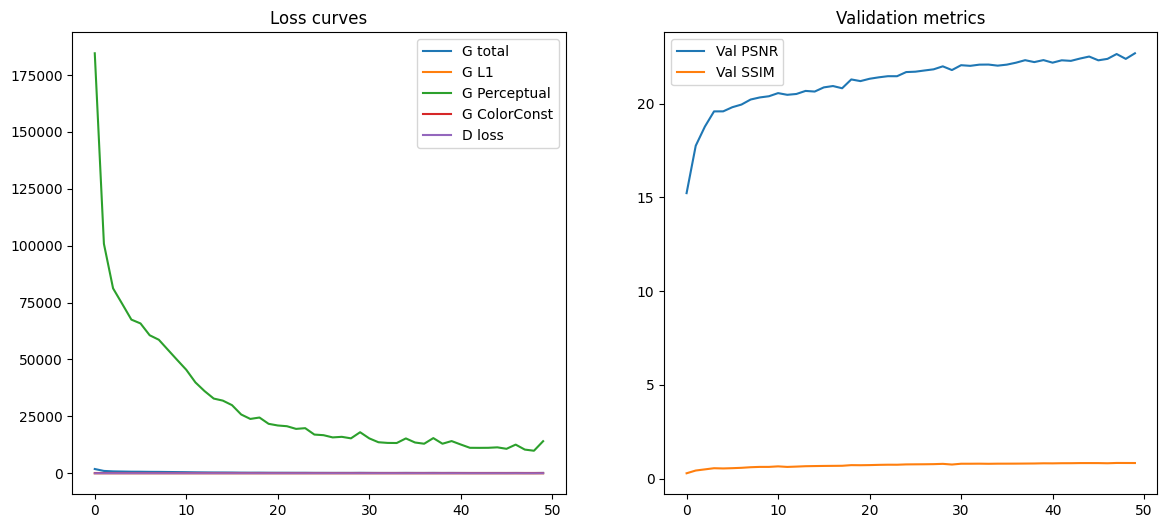

In [ ]:
# CELL 11 — plotting
import pandas as pd
hist_df = pd.DataFrame(history)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist_df["g_total_loss"], label="G total")
plt.plot(hist_df["g_l1_loss"], label="G L1")
plt.plot(hist_df["g_perc_loss"], label="G Perceptual")
plt.plot(hist_df["g_color_loss"], label="G ColorConst")
plt.plot(hist_df["d_loss"], label="D loss")
plt.legend(); plt.title("Loss curves")

plt.subplot(1,2,2)
plt.plot(hist_df["val_psnr"], label="Val PSNR")
plt.plot(hist_df["val_ssim"], label="Val SSIM")
plt.legend(); plt.title("Validation metrics")

plt.show()

**sample predictions**

In [ ]:
# CELL 12 — show sample predictions from validation
def show_predictions(n=5, ds=val_ds):
    for i,(inp,tar) in enumerate(ds.take(n)):
        pred = generator(inp, training=False)[0]
        inp_01 = (inp[0] + 1.0)/2.0
        tar_01 = (tar[0] + 1.0)/2.0
        pred_01 = (pred + 1.0)/2.0
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(np.clip(inp_01,0,1)); plt.title("B/W (input)"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(np.clip(tar_01,0,1)); plt.title("Ground truth"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(np.clip(pred_01,0,1)); plt.title("Predicted"); plt.axis('off')
        plt.show()

show_predictions(5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# CELL 13 — compute pixel-wise confusion matrix on small sample (quantized ab)
from sklearn.metrics import confusion_matrix

def rgb_to_ab_bins(rgb_images, n_bins=16):
    labs = color.rgb2lab(rgb_images)  # expects in [0,1]
    a = labs[...,1]; b = labs[...,2]
    a_norm = (a + 128) / 256.0
    b_norm = (b + 128) / 256.0
    a_idx = np.clip((a_norm * n_bins).astype(int), 0, n_bins-1)
    b_idx = np.clip((b_norm * n_bins).astype(int), 0, n_bins-1)
    bins = a_idx * n_bins + b_idx
    return bins

# sample small set
n_bins = 16
sample_idx = np.random.choice(val_gray.shape[0], size=min(5, val_gray.shape[0]), replace=False)
y_true_all, y_pred_all = [], []
for i in sample_idx:
    inp = np.expand_dims(val_gray[i], 0)
    pred = generator(inp, training=False)[0].numpy()
    pred_01 = (pred + 1)/2.0
    true_01 = (val_color[i] + 1)/2.0
    y_true_all.append(rgb_to_ab_bins(true_01).flatten())
    y_pred_all.append(rgb_to_ab_bins(pred_01).flatten())

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_bins*n_bins))
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (256, 256)


**Save final generator and training history**

In [ ]:
# CELL 14 — save best / final model and history CSV
final_gen_path = os.path.join(CKPT_DIR, "generator_final.h5")
generator.save(final_gen_path)
import pandas as pd
pd.DataFrame(history).to_csv(os.path.join(CKPT_DIR, "training_history.csv"), index=False)
print("Saved final model to:", final_gen_path)
print("Saved history CSV to:", os.path.join(CKPT_DIR, "training_history.csv"))

Saved final model to: /content/drive/MyDrive/checkpoint1/generator_final.h5
Saved history CSV to: /content/drive/MyDrive/checkpoint1/training_history.csv


In [1]:
# === Option A: Gradio (fast; no ngrok token required) ===
!pip install -q gradio tensorflow pillow

import gradio as gr
import tensorflow as tf
from PIL import Image
import numpy as np
import os

GEN_MODEL_PATH = "/content/drive/MyDrive/checkpoint1/generator_final.h5"  # <--- change to your .h5
assert os.path.exists(GEN_MODEL_PATH), f"Model not found at {GEN_MODEL_PATH}"

# load generator (compile=False)
generator = tf.keras.models.load_model(GEN_MODEL_PATH, compile=False)
IMG_SIZE = 256

def preprocess(img: Image.Image):
    img = img.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)
    arr = (arr / 127.5) - 1.0
    arr = np.expand_dims(arr, 0)
    return arr

def postprocess(out):
    out = (out + 1.0) / 2.0
    out = np.clip(out, 0.0, 1.0)
    out = (out*255).astype(np.uint8)
    return Image.fromarray(out)

def predict(input_img):
    x = preprocess(input_img)
    pred = generator.predict(x)[0]
    return postprocess(pred)

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil", label="Upload B/W image"),
                    outputs=gr.Image(type="pil", label="Predicted Color"),
                    title="B&W -> Color GAN",
                    description="Upload a grayscale image to colorize with your generator model.")
# run with share=True -> public URL printed
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7425f6c2874e5f1122.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
